# Causal mediation analysis 

The objective of this notebook is to develop a basic understanding of causal mediation analysis on a toy example.

In [1]:
import sklearn
from sklearn import cluster, datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import LogisticRegressionCV, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.calibration import CalibratedClassifierCV
from scipy.special import expit
import pandas as pd

## Dataset

In [252]:
rng = np.random.RandomState(170)

def get_features_and_labels(dataset_name='blobs_overlap', n_samples=10000, overlap_coefficient=1):
    ### Create dataset features

    if dataset_name == 'noisymoons':
        X, l = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=170)

    elif dataset_name == 'blobs_no_overlap':
        X, l = datasets.make_blobs(
            n_samples=n_samples, centers=2, cluster_std=[2., 2.], random_state=170
        )

    elif dataset_name == 'blobs_overlap':
        X, l = datasets.make_blobs(
            n_samples=n_samples, centers=[[0., 1.], [0.,0.]], cluster_std=[2.*overlap_coefficient, 2.*overlap_coefficient], random_state=170
        )

    else:
        raise NotImplementedError

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, l

In [253]:
### Plot options

number_classes = [2]

colors = np.array(
    list(
        islice(
            cycle(
                [
                    "#377eb8",
                    "#ff7f00",
                    "#4daf4a",
                    "#f781bf",
                    "#a65628",
                    "#984ea3",
                    "#999999",
                    "#e41a1c",
                    "#dede00",
                ]
            ),
            int(max(number_classes) + 1),
        )
    )
)

markers = np.array(
    list(
        islice(
            cycle(
                [
                    ".",
                    "+",
                    "x",
                    "v",
                    "s",
                    "p",
                ]
            ),
            int(max(number_classes) + 1),
        )
    )
)

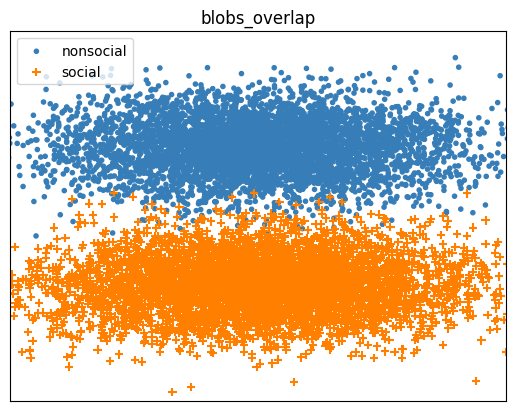

In [315]:
def visualise_data(dataset_name='blobs_overlap'):

    X, l = get_features_and_labels(dataset_name, overlap_coefficient=0.1)
    ### Dataset visualisation

    reg = LogisticRegression().fit(X, l)
    l_fitted = reg.predict(X)
    l_fitted
    markers = np.array(['.', '+'], dtype=str)
    labels = ['nonsocial', 'social']

    # plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_fitted], marker=markers[y])
    for i, c in enumerate(np.unique(l)):
        plt.scatter(X[:,0][l==c],X[:,1][l==c],color=colors[l][l==c], marker=markers[i], label=labels[i])

    plt.plot()
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.title(dataset_name)
    plt.legend()
    plt.savefig('{}.pdf'.format(dataset_name))

visualise_data()

In [258]:
def generate_causal_data(dataset_name, n_samples, mediator_binary, overlap_coefficient=1):
    
    X, l = get_features_and_labels(dataset_name, n_samples, overlap_coefficient=overlap_coefficient)
    # Treatments and other quantities

    T = rng.choice([0,1], size=(n_samples,1))
    np.mean(X, axis=0)
    #mean_X = np.array([0.5, 0.25])
    mean_X = np.array([0., 0.])
    
    # Coefficients
    reg = LinearRegression().fit(X, l)
    reg.score(X, l), reg.coef_, reg.intercept_
    beta_0 = reg.intercept_
    beta_X = reg.coef_

    beta_T = np.array([1])
    beta_TX = np.array([0,0])
    omega_T = 0.9

    gamma_0 = 0
    gamma_X = np.array([0,0]) 
    gamma_T = np.array([0.2])
    gamma_M = np.array([1])
    gamma_MT = np.array([0])
    omega_M = 0.9
    
    ### Mediator generation

    if mediator_binary:
        p = expit(beta_0 + X.dot(beta_X) + omega_T*T.dot(beta_T) + (T*X).dot(beta_TX) )
        M_ = rng.binomial(1, p)
        M = np.expand_dims(M_, axis=-1) 

    else:
        M_ = beta_0 + X.dot(beta_X) + omega_T*T.dot(beta_T) + (T*X).dot(beta_TX) + rng.normal(0, 0.1, size=T.shape[0])
        M = np.expand_dims(M_, axis=-1)

    Y = gamma_0 + X.dot(gamma_X) + T.dot(gamma_T) + omega_M*M.dot(gamma_M) + (T*M).dot(gamma_MT) + rng.normal(0, 0.1, size=T.shape[0])
    
    causal_data = X, T, M, Y
    
    ### Causal quantities
    
    if mediator_binary:
        mean_M_t1 = np.mean(expit(beta_0 + X.dot(beta_X) + X.dot(beta_TX) + omega_T *beta_T), axis=0)
        mean_M_t0 = np.mean(expit(beta_0 + X.dot(beta_X)), axis=0)
        theta_1 = gamma_T + gamma_MT.T.dot(mean_M_t1) # to do mean(m1) pour avoir un vecteur de taille dim_m
        theta_0 = gamma_T + gamma_MT.T.dot(mean_M_t0)
        product_mean_term = expit(beta_0 + X.dot(beta_X) + X.dot(beta_TX) + omega_T *beta_T) - expit(beta_0 + X.dot(beta_X))

        delta_1 = np.mean(product_mean_term*(omega_M * gamma_M+gamma_MT), axis=0)
        delta_0 = np.mean(product_mean_term*(omega_M * gamma_M), axis=0)
        tau = delta_0 + theta_1

    else:
        mean_M_t1 = beta_0 + mean_X.dot(beta_X) + mean_X.dot(beta_TX) + omega_T *beta_T
        mean_M_t0 = beta_0 + mean_X.dot(beta_X)

        theta_1 = gamma_T + gamma_MT.T.dot(mean_M_t1) # to do mean(m1) pour avoir un vecteur de taille dim_m
        theta_0 = gamma_T + gamma_MT.T.dot(mean_M_t0)
        #delta_1 = (gamma_T * t1 + m1.dot(gamma_m) + m1.dot(gamma_t_m) * t1 - gamma_t * t1 + m0.dot(gamma_m) + m0.dot(gamma_t_m) * t1).mean()
        #delta_0 = (gamma_T * t0 + m1.dot(gamma_m) + m1.dot(gamma_t_m) * t0 - gamma_t * t0 + m0.dot(gamma_m) + m0.dot(gamma_t_m) * t0).mean()
        delta_1 = (mean_X.dot(beta_TX) + omega_T * beta_T) * (omega_M * gamma_M + gamma_MT)
        delta_0 = (mean_X.dot(beta_TX) + omega_T * beta_T) * (omega_M * gamma_M)

        tau = gamma_T + omega_M * gamma_M * omega_T * beta_T
        
    causal_effects = [tau[0], theta_1[0], theta_0[0], delta_1, delta_0, 0]
    
    return causal_data, causal_effects

In [259]:
#((T*X).dot(beta_TX)).shape
#linear_X = beta_0 + X.dot(beta_X)
#linear_T = omega_T*T.dot(beta_T)
#linear_TX = (T*X).dot(beta_TX)
#noise = rng.normal(0, 0.1, size=T.shape[0])
dataset_name='blobs_overlap'
n_samples=10000
mediator_binary=False

In [7]:
causal_data, causal_effects = generate_causal_data(dataset_name, n_samples, mediator_binary)

## Causal effect estimation

In [8]:
CV_FOLDS = 5
ALPHAS = np.logspace(-5, 5, 8)

### Importance weighting

In [163]:
def get_classifier(regularization=False, forest=False, calibration=True, calib_method='sigmoid'):
    if regularization:
        cs = ALPHAS
    else:
        cs = [np.inf]
        
    if not forest:
        x_clf = LogisticRegressionCV(Cs=cs, cv=CV_FOLDS)
        xm_clf = LogisticRegressionCV(Cs=cs, cv=CV_FOLDS)
    else:
        x_clf = RandomForestClassifier(n_estimators=100,
                                              min_samples_leaf=10)
        xm_clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)
    if calibration:
        x_clf = CalibratedClassifierCV(x_clf,
                                         method=calib_method)
        xm_clf = CalibratedClassifierCV(xm_clf, method=calib_method)
            
    return x_clf, xm_clf
    
def get_train_test_lists(crossfit, n): 
    if crossfit < 2:
        train_test_list = [[np.arange(n), np.arange(n)]]
    else:
        kf = KFold(n_splits=crossfit)
        train_test_list = list()
        for train_index, test_index in kf.split(x):
            train_test_list.append([train_index, test_index])
    return train_test_list

def estimate_probabilities(t, m, x, crossfit, classifier_x, classifier_xm):
    
    n = len(t)
    train_test_list = [[np.arange(n), np.arange(n)]]
    
    p_x, p_xm = [np.zeros(n) for h in range(2)]
    # compute propensity scores
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    if len(m.shape) == 1:
        m = m.reshape(-1, 1)
    
    train_test_list = get_train_test_lists(crossfit, n)
    
    for train_index, test_index in train_test_list:
        x_clf = classifier_x.fit(x[train_index, :], t[train_index])
        xm_clf = classifier_xm.fit(np.hstack((x, m))[train_index, :], t[train_index])
        p_x[test_index] = x_clf.predict_proba(x[test_index, :])[:, 1]
        p_xm[test_index] = xm_clf.predict_proba(
            np.hstack((x, m))[test_index, :])[:, 1]
        
    return p_x, p_xm

def SNIPW(y, t, m, x, trim, p_x, p_xm, clip):
    """
    IPW estimator presented in
    HUBER, Martin. Identifying causal mechanisms (primarily) based on inverse
    probability weighting. Journal of Applied Econometrics, 2014,
    vol. 29, no 6, p. 920-943.

    results has 6 values
    - total effect
    - direct effect treated (\theta(1))
    - direct effect non treated (\theta(0))
    - indirect effect treated (\delta(1))
    - indirect effect untreated (\delta(0))
    - number of used observations (non trimmed)

    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples, n_features_mediator)
            mediator value for each unit, can be continuous or binary, and
            multi-dimensional

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values


    trim    float
            Trimming rule for discarding observations with extreme propensity
            scores. In the absence of post-treatment confounders (w=NULL),
            observations with Pr(D=1|M,X)<trim or Pr(D=1|M,X)>(1-trim) are
            dropped. In the presence of post-treatment confounders
            (w is defined), observations with Pr(D=1|M,W,X)<trim or
            Pr(D=1|M,W,X)>(1-trim) are dropped.

    logit   boolean
            whether logit or pobit regression is used for propensity score
            legacy from the R package, here only logit is implemented

    regularization boolean, default True
                   whether to use regularized models (logistic or
                   linear regression). If True, cross-validation is used
                   to chose among 8 potential log-spaced values between
                   1e-5 and 1e5

    forest  boolean, default False
            whether to use a random forest model to estimate the propensity
            scores instead of logistic regression

    crossfit integer, default 0
             number of folds for cross-fitting

    clip    float
            limit to clip for numerical stability (min=clip, max=1-clip)
    """
    
    t = t.squeeze()
    
    # trimming. Following causal weight code, not sure I understand
    # why we trim only on p_xm and not on p_x
    ind = ((p_xm > trim) & (p_xm < (1 - trim)))
    y, t, p_x, p_xm = y[ind], t[ind], p_x[ind], p_xm[ind]

    # note on the names, ytmt' = Y(t, M(t')), the treatment needs to be
    # binary but not the mediator
    p_x = np.clip(p_x, clip, 1 - clip)
    p_xm = np.clip(p_xm, clip, 1 - clip)

    y1m1 = np.sum(y * t / p_x) / np.sum(t / p_x)
    y1m0 = np.sum(y * t * (1 - p_xm) / (p_xm * (1 - p_x))) /\
        np.sum(t * (1 - p_xm) / (p_xm * (1 - p_x)))
    y0m0 = np.sum(y * (1 - t) / (1 - p_x)) /\
        np.sum((1 - t) / (1 - p_x))
    y0m1 = np.sum(y * (1 - t) * p_xm / ((1 - p_xm) * p_x)) /\
        np.sum((1 - t) * p_xm / ((1 - p_xm) * p_x))

    return(y1m1 - y0m0,
           y1m1 - y0m1,
           y1m0 - y0m0,
           y1m1 - y1m0,
           y0m1 - y0m0,
           np.sum(ind))

def IPW(y, t, m, x, trim, p_x, p_xm, clip):
    """
    IPW estimator presented in
    HUBER, Martin. Identifying causal mechanisms (primarily) based on inverse
    probability weighting. Journal of Applied Econometrics, 2014,
    vol. 29, no 6, p. 920-943.

    results has 6 values
    - total effect
    - direct effect treated (\theta(1))
    - direct effect non treated (\theta(0))
    - indirect effect treated (\delta(1))
    - indirect effect untreated (\delta(0))
    - number of used observations (non trimmed)

    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples, n_features_mediator)
            mediator value for each unit, can be continuous or binary, and
            multi-dimensional

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values


    trim    float
            Trimming rule for discarding observations with extreme propensity
            scores. In the absence of post-treatment confounders (w=NULL),
            observations with Pr(D=1|M,X)<trim or Pr(D=1|M,X)>(1-trim) are
            dropped. In the presence of post-treatment confounders
            (w is defined), observations with Pr(D=1|M,W,X)<trim or
            Pr(D=1|M,W,X)>(1-trim) are dropped.

    logit   boolean
            whether logit or pobit regression is used for propensity score
            legacy from the R package, here only logit is implemented

    regularization boolean, default True
                   whether to use regularized models (logistic or
                   linear regression). If True, cross-validation is used
                   to chose among 8 potential log-spaced values between
                   1e-5 and 1e5

    forest  boolean, default False
            whether to use a random forest model to estimate the propensity
            scores instead of logistic regression

    crossfit integer, default 0
             number of folds for cross-fitting

    clip    float
            limit to clip for numerical stability (min=clip, max=1-clip)
    """
    
    t = t.squeeze()
    
    # trimming. Following causal weight code, not sure I understand
    # why we trim only on p_xm and not on p_x
    # trimming. Following causal weight code, not sure I understand
    # why we trim only on p_xm and not on p_x
    ind = ((p_xm > trim) & (p_xm < (1 - trim)))
    y, t, p_x, p_xm = y[ind], t[ind], p_x[ind], p_xm[ind]

    # note on the names, ytmt' = Y(t, M(t')), the treatment needs to be
    # binary but not the mediator
    p_x = np.clip(p_x, clip, 1 - clip)
    p_xm = np.clip(p_xm, clip, 1 - clip)

    y1m1 = np.mean(y * t / p_x)
    y1m0 = np.mean(y * t * (1 - p_xm) / (p_xm * (1 - p_x))) 
    y0m0 = np.mean(y * (1 - t) / (1 - p_x))
    y0m1 = np.mean(y * (1 - t) * p_xm / ((1 - p_xm) * p_x)) 

    return(y1m1 - y0m0,
           y1m1 - y0m1,
           y1m0 - y0m0,
           y1m1 - y1m0,
           y0m1 - y0m0,
           np.sum(ind))


In [164]:
# y = Y
# t = T
# m = M
# x = X
# trim=0
# logit=True
# regularization=False
# forest=False
# crossfit=0
# clip=0.0
# calibration=False
# classifier_x, classifier_xm = get_classifier(regularization, forest, calibration)

In [11]:
# p_x, p_xm = estimate_probabilities(t, m, x, crossfit, classifier_x, classifier_xm)
# effects_IPW = IPW(y, t, m, x, trim, p_x, p_xm)
# effects_SNIPW = SNIPW(y, t, m, x, trim, p_x, p_xm)

In [12]:
# tau_hat, theta_1_hat, theta_0_hat, delta_1_hat, delta_0_hat, n_non_trimmed = effects_IPW

In [13]:
# print("IPW")
# print("Direct effects")
# print("True theta1:{}, estimated theta1: {}".format(theta_1, round(theta_1_hat,3)))
# print("True theta0:{}, estimated theta0: {}".format(theta_0, round(theta_0_hat,3)))
# print("\\")
# print("Indirect effects")
# print("True delta1:{}, estimated delta1: {}".format(delta_1, round(delta_1_hat,3)))
# print("True delta0:{}, estimated delta0: {}".format(delta_0, round(delta_0_hat,3)))
# print("\\")
# print("Total effect")
# print("True tau:{}, estimated tau: {}".format(tau, round(tau_hat,3)))

In [14]:
# tau_hat, theta_1_hat, theta_0_hat, delta_1_hat, delta_0_hat, n_non_trimmed = effects_SNIPW
# print("SNIPW")
# print("Direct effects")
# print("True theta1:{}, estimated theta1: {}".format(theta_1, round(theta_1_hat,3)))
# print("True theta0:{}, estimated theta0: {}".format(theta_0, round(theta_0_hat,3)))
# print("\\")
# print("Indirect effects")
# print("True delta1:{}, estimated delta1: {}".format(delta_1, round(delta_1_hat,3)))
# print("True delta0:{}, estimated delta0: {}".format(delta_0, round(delta_0_hat,3)))
# print("\\")
# print("Total effect")
# print("True tau:{}, estimated tau: {}".format(tau, round(tau_hat,3)))

### Ordinary least squares

In [165]:
def ols_mediation(y, t, m, x, interaction=False, regularization=True):
    """
    found an R implementation https://cran.r-project.org/package=regmedint

    implements very simple model of mediation
    Y ~ X + T + M
    M ~ X + T
    estimation method is product of coefficients

    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples)
            mediator value for each unit, can be continuous or binary, and
            is necessary in 1D

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values

    interaction boolean, default=False
                whether to include interaction terms in the model
                not implemented here, just for compatibility of signature
                function

    regularization boolean, default True
                   whether to use regularized models (logistic or
                   linear regression). If True, cross-validation is used
                   to chose among 8 potential log-spaced values between
                   1e-5 and 1e5

    """
    if regularization:
        alphas = ALPHAS
    else:
        alphas = [0.0]
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    if len(m.shape) == 1:
        m = m.reshape(-1, 1)
    if len(t.shape) == 1:
        t = t.reshape(-1, 1)
    coef_t_m = np.zeros(m.shape[1])
    for i in range(m.shape[1]):
        m_reg = RidgeCV(alphas=alphas, cv=CV_FOLDS)\
            .fit(np.hstack((x, t)), m[:, i])
        coef_t_m[i] = m_reg.coef_[-1]
    y_reg = RidgeCV(alphas=alphas, cv=CV_FOLDS)\
        .fit(np.hstack((x, t, m)), y.ravel())

    # return total, direct and indirect effect
    direct_effect = y_reg.coef_[x.shape[1]]
    indirect_effect = sum(y_reg.coef_[x.shape[1] + 1:] * coef_t_m)
    return [direct_effect + indirect_effect,
            direct_effect,
            direct_effect,
            indirect_effect,
            indirect_effect,
            None]


In [16]:
# effects_linear = ols_mediation(y, t, m, x)

# tau_hat, theta_1_hat, theta_0_hat, delta_1_hat, delta_0_hat, n_non_trimmed = effects_linear
# print("Linear coefficients")
# print("Direct effects")
# print("True theta1:{}, estimated theta1: {}".format(theta_1, round(theta_1_hat,3)))
# print("True theta0:{}, estimated theta0: {}".format(theta_0, round(theta_0_hat,3)))
# print("\\")
# print("Indirect effects")
# print("True delta1:{}, estimated delta1: {}".format(delta_1, round(delta_1_hat,3)))
# print("True delta0:{}, estimated delta0: {}".format(delta_0, round(delta_0_hat,3)))
# print("\\")
# print("Total effect")
# print("True tau:{}, estimated tau: {}".format(tau, round(tau_hat,3)))

### G computation

In [12]:
def get_interactions(interaction, *args):
    """
    this function provides interaction terms between different groups of
    variables (confounders, treatment, mediators)
    Inputs
    --------
    interaction     boolean
                    whether to compute interaction terms

    *args           flexible, one or several arrays
                    blocks of variables between which interactions should be
                    computed
    Returns
    --------
    Examples
    --------
    >>> x = np.arange(6).reshape(3, 2)
    >>> t = np.ones((3, 1))
    >>> m = 2 * np.ones((3, 1))
    >>> get_interactions(False, x, t, m)
    array([[0., 1., 1., 2.],
           [2., 3., 1., 2.],
           [4., 5., 1., 2.]])
    >>> get_interactions(True, x, t, m)
    array([[ 0.,  1.,  1.,  2.,  0.,  1.,  0.,  2.,  2.],
           [ 2.,  3.,  1.,  2.,  2.,  3.,  4.,  6.,  2.],
           [ 4.,  5.,  1.,  2.,  4.,  5.,  8., 10.,  2.]])
    """
    variables = list(args)
    for index, var in enumerate(variables):
        if len(var.shape) == 1:
            variables[index] = var.reshape(-1,1)
    pre_inter_variables = np.hstack(variables)
    if not interaction:
        return pre_inter_variables
    new_cols = list()
    for i, var in enumerate(variables[:]):
        for j, var2 in enumerate(variables[i+1:]):
            for ii in range(var.shape[1]):
                for jj in range(var2.shape[1]):
                    new_cols.append((var[:, ii] * var2[:, jj]).reshape(-1, 1))
    new_vars = np.hstack(new_cols)
    result = np.hstack((pre_inter_variables, new_vars))
    return result

def g_computation(y, t, m, x, interaction=False, forest=False,
                  crossfit=0, calibration=True, regularization=True,
                  calib_method='sigmoid'):
    """
    m is binary !!!

    implementation of the g formula for mediation

    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples)
            mediator value for each unit, here m is necessary binary and uni-
            dimensional

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values

    interaction boolean, default=False
                whether to include interaction terms in the model
                interactions are terms XT, TM, MX

    forest  boolean, default False
            whether to use a random forest model to estimate the propensity
            scores instead of logistic regression, and outcome model instead
            of linear regression

    crossfit integer, default 0
             number of folds for cross-fitting

    regularization boolean, default True
                   whether to use regularized models (logistic or
                   linear regression). If True, cross-validation is used
                   to chose among 8 potential log-spaced values between
                   1e-5 and 1e5
    """
    if regularization:
        alphas = ALPHAS
        cs = ALPHAS
    else:
        alphas = [0.0]
        cs = [np.inf]
    n = len(y)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    if len(m.shape) == 1:
        mr = m.reshape(-1, 1)
    else:
        mr = np.copy(m)
    if len(t.shape) == 1:
        t = t.reshape(-1, 1)
    t0 = np.zeros((n, 1))
    t1 = np.ones((n, 1))
    m0 = np.zeros((n, 1))
    m1 = np.ones((n, 1))

    if crossfit < 2:
        train_test_list = [[np.arange(n), np.arange(n)]]
    else:
        kf = KFold(n_splits=crossfit)
        train_test_list = list()
        for train_index, test_index in kf.split(x):
            train_test_list.append([train_index, test_index])
    mu_11x, mu_10x, mu_01x, mu_00x, f_00x, f_01x, f_10x, f_11x = \
        [np.zeros(n) for h in range(8)]

    for train_index, test_index in train_test_list:
        if not forest:
            y_reg = RidgeCV(alphas=alphas, cv=CV_FOLDS)\
                .fit(get_interactions(interaction, x, t, mr)[train_index, :], y[train_index])
            pre_m_prob = LogisticRegressionCV(Cs=cs, cv=CV_FOLDS)\
                .fit(get_interactions(interaction, t, x)[train_index, :], m.ravel()[train_index])
        else:
            y_reg = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)\
                .fit(get_interactions(interaction, x, t, mr)[train_index, :], y[train_index])
            pre_m_prob = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)\
                .fit(get_interactions(interaction, t, x)[train_index, :], m.ravel()[train_index])
        if calibration:
            m_prob = CalibratedClassifierCV(pre_m_prob, method=calib_method)\
                .fit(get_interactions(
                    interaction, t, x)[train_index, :], m.ravel()[train_index])
        else:
            m_prob = pre_m_prob
        mu_11x[test_index] = y_reg.predict(get_interactions(interaction, x, t1, m1)[test_index, :])
        mu_10x[test_index] = y_reg.predict(get_interactions(interaction, x, t1, m0)[test_index, :])
        mu_01x[test_index] = y_reg.predict(get_interactions(interaction, x, t0, m1)[test_index, :])
        mu_00x[test_index] = y_reg.predict(get_interactions(interaction, x, t0, m0)[test_index, :])
        f_00x[test_index] = m_prob.predict_proba(get_interactions(interaction, t0, x)[test_index, :])[:, 0]
        f_01x[test_index] = m_prob.predict_proba(get_interactions(interaction, t0, x)[test_index, :])[:, 1]
        f_10x[test_index] = m_prob.predict_proba(get_interactions(interaction, t1, x)[test_index, :])[:, 0]
        f_11x[test_index] = m_prob.predict_proba(get_interactions(interaction, t1, x)[test_index, :])[:, 1]

    direct_effect_i1 = mu_11x - mu_01x
    direct_effect_i0 = mu_10x - mu_00x
    direct_effect_treated = (direct_effect_i1 * f_11x + direct_effect_i0 * f_10x).sum() / n
    direct_effect_control = (direct_effect_i1 * f_01x + direct_effect_i0 * f_00x).sum() / n
    indirect_effect_i1 = f_11x - f_01x
    indirect_effect_i0 = f_10x - f_00x
    indirect_effect_treated = (indirect_effect_i1 * mu_11x + indirect_effect_i0 * mu_10x).sum() / n
    indirect_effect_control = (indirect_effect_i1 * mu_01x + indirect_effect_i0 * mu_00x).sum() / n
    total_effect = direct_effect_control + indirect_effect_treated

    return [total_effect,
            direct_effect_treated,
            direct_effect_control,
            indirect_effect_treated,
            indirect_effect_control,
            None]

In [13]:
# effects_g_computation = g_computation(y, t, m, x)

# tau_hat, theta_1_hat, theta_0_hat, delta_1_hat, delta_0_hat, n_non_trimmed = effects_linear
# print("Linear coefficients")
# print("Direct effects")
# print("True theta1:{}, estimated theta1: {}".format(theta_1, round(theta_1_hat,3)))
# print("True theta0:{}, estimated theta0: {}".format(theta_0, round(theta_0_hat,3)))
# print("\\")
# print("Indirect effects")
# print("True delta1:{}, estimated delta1: {}".format(delta_1, round(delta_1_hat,3)))
# print("True delta0:{}, estimated delta0: {}".format(delta_0, round(delta_0_hat,3)))
# print("\\")
# print("Total effect")
# print("True tau:{}, estimated tau: {}".format(tau, round(tau_hat,3)))

### Multiply robust estimator

In [166]:
def get_regressions(regularization=False, interaction=False, forest=False, calibration=True, calib_method='sigmoid'):
    if regularization:
        alphas, cs = ALPHAS, ALPHAS
    else:
        alphas, cs = [0.0], [np.inf]
        
    # mu_tm, f_mtx, and p_x model fitting
    if not forest:
        y_reg = RidgeCV(alphas=alphas, cv=CV_FOLDS)
        pre_m_prob = LogisticRegressionCV(Cs=cs, cv=CV_FOLDS)
        pre_p_x_clf = LogisticRegressionCV(Cs=cs, cv=CV_FOLDS)
    else:
        y_reg = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)
        pre_m_prob = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)
        pre_p_x_clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)
    if calibration:
        m_prob = CalibratedClassifierCV(pre_m_prob, method=calib_method)
        p_x_clf = CalibratedClassifierCV(pre_p_x_clf, method=calib_method)
    else:
        m_prob = pre_m_prob
        p_x_clf = pre_p_x_clf
            
    return y_reg, m_prob, p_x_clf
    
def get_train_test_lists(crossfit, n): 
    if crossfit < 2:
        train_test_list = [[np.arange(n), np.arange(n)]]
    else:
        kf = KFold(n_splits=crossfit)
        train_test_list = list(kf.split(x))
        
    return train_test_list

def estimate_probabilities(t, m, x, crossfit, classifier_x, classifier_xm):
    
    n = len(t)
    train_test_list = [[np.arange(n), np.arange(n)]]
    
    p_x, p_xm = [np.zeros(n) for h in range(2)]
    # compute propensity scores
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    if len(m.shape) == 1:
        m = m.reshape(-1, 1)
    
    train_test_list = get_train_test_lists(crossfit, n)
    
    for train_index, test_index in train_test_list:
        x_clf = classifier_x.fit(x[train_index, :], t[train_index])
        xm_clf = classifier_xm.fit(np.hstack((x, m))[train_index, :], t[train_index])
        p_x[test_index] = x_clf.predict_proba(x[test_index, :])[:, 1]
        p_xm[test_index] = xm_clf.predict_proba(
            np.hstack((x, m))[test_index, :])[:, 1]
        
    return p_x, p_xm

def get_interactions(interaction, *args):
    """
    this function provides interaction terms between different groups of
    variables (confounders, treatment, mediators)
    Inputs
    --------
    interaction     boolean
                    whether to compute interaction terms

    *args           flexible, one or several arrays
                    blocks of variables between which interactions should be
                    computed
    Returns
    --------
    Examples
    --------
    >>> x = np.arange(6).reshape(3, 2)
    >>> t = np.ones((3, 1))
    >>> m = 2 * np.ones((3, 1))
    >>> get_interactions(False, x, t, m)
    array([[0., 1., 1., 2.],
           [2., 3., 1., 2.],
           [4., 5., 1., 2.]])
    >>> get_interactions(True, x, t, m)
    array([[ 0.,  1.,  1.,  2.,  0.,  1.,  0.,  2.,  2.],
           [ 2.,  3.,  1.,  2.,  2.,  3.,  4.,  6.,  2.],
           [ 4.,  5.,  1.,  2.,  4.,  5.,  8., 10.,  2.]])
    """
    variables = list(args)
    for index, var in enumerate(variables):
        if len(var.shape) == 1:
            variables[index] = var.reshape(-1,1)
    pre_inter_variables = np.hstack(variables)
    if not interaction:
        return pre_inter_variables
    new_cols = list()
    for i, var in enumerate(variables[:]):
        for j, var2 in enumerate(variables[i+1:]):
            for ii in range(var.shape[1]):
                for jj in range(var2.shape[1]):
                    new_cols.append((var[:, ii] * var2[:, jj]).reshape(-1, 1))
    new_vars = np.hstack(new_cols)
    result = np.hstack((pre_inter_variables, new_vars))
    return result

def multiply_robust_efficient(
    y,
    t,
    m,
    x,
    interaction=False,
    forest=False,
    crossfit=0,
    trim=0.01,
    regularization=True,
    calibration=True,
    calib_method="sigmoid",
):
    """
    Presented in Eric J. Tchetgen Tchetgen. Ilya Shpitser.
    "Semiparametric theory for causal mediation analysis: Efficiency bounds,
    multiple robustness and sensitivity analysis."
    Ann. Statist. 40 (3) 1816 - 1845, June 2012.
    https://doi.org/10.1214/12-AOS990

    Parameters
    ----------
    y : array-like, shape (n_samples)
        Outcome value for each unit, continuous

    t : array-like, shape (n_samples)
        Treatment value for each unit, binary

    m : array-like, shape (n_samples)
        Mediator value for each unit, binary and unidimensional

    x : array-like, shape (n_samples, n_features_covariates)
        Covariates value for each unit, continuous

    interaction : boolean, default=False
        Whether to include interaction terms in the model
        interactions are terms XT, TM, MX

    forest : boolean, default=False
        Whether to use a random forest model to estimate the propensity
        scores instead of logistic regression, and outcome model instead
        of linear regression

    crossfit : integer, default=0
        Number of folds for cross-fitting. If crossfit<2, no cross-fitting is applied

    trim : float, default=0.01
        Limit to trim p_x and f_mtx for numerical stability (min=trim, max=1-trim)

    regularization : boolean, default=True
        Whether to use regularized models (logistic or linear regression).
        If True, cross-validation is used to chose among 8 potential
        log-spaced values between 1e-5 and 1e5

    calibration : boolean, default=True
        Whether to add a calibration step so that the classifier used to estimate
        the treatment propensity score and the density of the (binary) mediator.
        Calibration ensures the output of the [predict_proba](https://scikit-learn.org/stable/glossary.html#term-predict_proba)
        method can be directly interpreted as a confidence level.

    calib_method : str, default="sigmoid"
        Which calibration method to use.
        Implemented calibration methods are "sigmoid" and "isotonic".


    Returns
    -------
    total : float
        Average total effect.
    direct1 : float
        Direct effect on the exposed.
    direct0 : float
        Direct effect on the unexposed,
    indirect1 : float
        Indirect effect on the exposed.
    indirect0 : float
        Indirect effect on the unexposed.
    n_discarded : int
        Number of discarded samples due to trimming.


    Raises
    ------
    ValueError
        - If t or y are multidimensional.
        - If x, t, m, or y don't have the same length.
        - If m is not binary.
    """
    # Format checking
    if len(y) != len(y.ravel()):
        raise ValueError("Multidimensional y is not supported")
    if len(t) != len(t.ravel()):
        raise ValueError("Multidimensional t is not supported")
    if len(m) != len(m.ravel()):
        raise ValueError("Multidimensional m is not supported")

    n = len(y)
    if len(x.shape) == 1:
        x.reshape(n, 1)
    if len(m.shape) == 1:
        m.reshape(n, 1)

    dim_m = m.shape[1]
    if n * dim_m != sum(m.ravel() == 1) + sum(m.ravel() == 0):
        raise ValueError("m is not binary")

    y = y.ravel()
    t = t.ravel()
    m = m.ravel()
    if n != len(x) or n != len(m) or n != len(t):
        raise ValueError("Inputs don't have the same number of observations")

    # Initialisation
    (
        p_x,  # P(T=1|X)
        f_00x,  # f(M=0|T=0,X)
        f_01x,  # f(M=0|T=1,X)
        f_10x,  # f(M=1|T=0,X)
        f_11x,  # f(M=1|T=1,X)
        f_m0x,  # f(M|T=0,X)
        f_m1x,  # f(M|T=1,X)
        mu_t1,  # E[Y|T=1,M,X]
        mu_t0,  # E[Y|T=0,M,X]
        mu_t1_m1,  # E[Y|T=1,M=1,X]
        mu_t1_m0,  # E[Y|T=1,M=0,X]
        mu_t0_m1,  # E[Y|T=0,M=1,X]
        mu_t0_m0,  # E[Y|T=0,M=0,X]
        E_mu_t0_t0,  # E[E[Y|T=0,M,X]|T=0,X]
        E_mu_t0_t1,  # E[E[Y|T=0,M,X]|T=1,X]
        E_mu_t1_t0,  # E[E[Y|T=1,M,X]|T=0,X]
        E_mu_t1_t1,  # E[E[Y|T=1,M,X]|T=1,X]
    ) = [np.zeros(n) for _ in range(17)]
    t0, m0 = np.zeros((n, 1)), np.zeros((n, 1))
    t1, m1 = np.ones((n, 1)), np.ones((n, 1))
    n_discarded = 0

    if regularization:
        alphas, cs = ALPHAS, ALPHAS
    else:
        alphas, cs = [0.0], [np.inf]

    train_test_list = get_train_test_lists(crossfit, n)

    # Cross-fitting loop
    for train_index, test_index in train_test_list:
        # Index declaration
        test_ind = np.arange(len(test_index))
        ind_t0 = t[test_index] == 0

        y_reg, m_prob, p_x_clf  = get_regressions(regularization, interaction, forest, calibration)
        y_reg.fit(
            get_interactions(interaction, x, t, m)[train_index, :], y[train_index]
        )
        m_prob.fit(
                get_interactions(interaction, t, x)[train_index, :], m[train_index]
            )
        p_x_clf.fit(
                x[train_index, :], t[train_index]
            )

        # predict P(T=1|X)
        p_x[test_index] = p_x_clf.predict_proba(x[test_index, :])[:, 1]

        # predict f(M=m|T=t,X)
        res = m_prob.predict_proba(get_interactions(interaction, t0, x)[test_index, :])
        f_00x[test_index] = res[:, 0]
        f_01x[test_index] = res[:, 1]
        res = m_prob.predict_proba(get_interactions(interaction, t1, x)[test_index, :])
        f_10x[test_index] = res[:, 0]
        f_11x[test_index] = res[:, 1]

        # predict f(M|T=t,X)
        f_m0x[test_index] = m_prob.predict_proba(
            get_interactions(interaction, t0, x)[test_index, :]
        )[test_ind, m[test_index]]
        f_m1x[test_index] = m_prob.predict_proba(
            get_interactions(interaction, t1, x)[test_index, :]
        )[test_ind, m[test_index]]

        # predict E[Y|T=t,M,X]
        mu_t1[test_index] = y_reg.predict(
            get_interactions(interaction, x, t1, m)[test_index, :]
        )
        mu_t0[test_index] = y_reg.predict(
            get_interactions(interaction, x, t0, m)[test_index, :]
        )

        # predict E[Y|T=t,M=m,X]
        mu_t0_m0[test_index] = y_reg.predict(
            get_interactions(interaction, x, t0, m0)[test_index, :]
        )
        mu_t0_m1[test_index] = y_reg.predict(
            get_interactions(interaction, x, t0, m1)[test_index, :]
        )
        mu_t1_m1[test_index] = y_reg.predict(
            get_interactions(interaction, x, t1, m1)[test_index, :]
        )
        mu_t1_m0[test_index] = y_reg.predict(
            get_interactions(interaction, x, t1, m0)[test_index, :]
        )

        # E[E[Y|T=1,M=m,X]|T=t,X] model fitting
        reg_y_t1m1_t0 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][ind_t0, :], mu_t1_m1[test_index][ind_t0]
        )
        reg_y_t1m0_t0 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][ind_t0, :], mu_t1_m0[test_index][ind_t0]
        )
        reg_y_t1m1_t1 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][~ind_t0, :], mu_t1_m1[test_index][~ind_t0]
        )
        reg_y_t1m0_t1 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][~ind_t0, :], mu_t1_m0[test_index][~ind_t0]
        )

        # predict E[E[Y|T=1,M=m,X]|T=t,X]
        E_mu_t1_t0[test_index] = (
            reg_y_t1m0_t0.predict(x[test_index, :]) * f_00x[test_index]
            + reg_y_t1m1_t0.predict(x[test_index, :]) * f_01x[test_index]
        )
        E_mu_t1_t1[test_index] = (
            reg_y_t1m0_t1.predict(x[test_index, :]) * f_10x[test_index]
            + reg_y_t1m1_t1.predict(x[test_index, :]) * f_11x[test_index]
        )

        # E[E[Y|T=0,M=m,X]|T=t,X] model fitting
        reg_y_t0m1_t0 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][ind_t0, :], mu_t0_m1[test_index][ind_t0]
        )
        reg_y_t0m0_t0 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][ind_t0, :], mu_t0_m0[test_index][ind_t0]
        )
        reg_y_t0m1_t1 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][~ind_t0, :], mu_t0_m1[test_index][~ind_t0]
        )
        reg_y_t0m0_t1 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][~ind_t0, :], mu_t0_m0[test_index][~ind_t0]
        )

        # predict E[E[Y|T=0,M=m,X]|T=t,X]
        E_mu_t0_t0[test_index] = (
            reg_y_t0m0_t0.predict(x[test_index, :]) * f_00x[test_index]
            + reg_y_t0m1_t0.predict(x[test_index, :]) * f_01x[test_index]
        )
        E_mu_t0_t1[test_index] = (
            reg_y_t0m0_t1.predict(x[test_index, :]) * f_10x[test_index]
            + reg_y_t0m1_t1.predict(x[test_index, :]) * f_11x[test_index]
        )

    # trimming
    p_x_trim = p_x != np.clip(p_x, trim, 1 - trim)
    f_m0x_trim = f_m0x != np.clip(f_m0x, trim, 1 - trim)
    f_m1x_trim = f_m1x != np.clip(f_m1x, trim, 1 - trim)
    trimmed = p_x_trim + f_m0x_trim + f_m1x_trim

    var_name = ["t", "y", "p_x", "f_m0x", "f_m1x", "mu_t1", "mu_t0"]
    var_name += ["E_mu_t1_t1", "E_mu_t0_t0", "E_mu_t1_t0", "E_mu_t0_t1"]

    for var in var_name:
        exec(f"{var} = {var}[~trimmed]")
    n_discarded += np.sum(trimmed)

    # ytmt computing
    y1m1 = t / p_x * (y - E_mu_t1_t1) + E_mu_t1_t1
    y0m0 = (1 - t) / (1 - p_x) * (y - E_mu_t0_t0) + E_mu_t0_t0
    y1m0 = (
        (t / p_x) * (f_m0x / f_m1x) * (y - mu_t1)
        + (1 - t) / (1 - p_x) * (mu_t1 - E_mu_t1_t0)
        + E_mu_t1_t0
    )
    y0m1 = (
        (1 - t) / (1 - p_x) * (f_m1x / f_m0x) * (y - mu_t0)
        + t / p_x * (mu_t0 - E_mu_t0_t1)
        + E_mu_t0_t1
    )

    # effects computing
    total = np.mean(y1m1 - y0m0)
    direct1 = np.mean(y1m1 - y0m1)
    direct0 = np.mean(y1m0 - y0m0)
    indirect1 = np.mean(y1m1 - y1m0)
    indirect0 = np.mean(y0m1 - y0m0)

    return total, direct1, direct0, indirect1, indirect0, n_discarded



In [20]:
# effects_MR = multiply_robust_efficient(y, t, m, x)

# tau_hat, theta_1_hat, theta_0_hat, delta_1_hat, delta_0_hat, n_non_trimmed = effects_linear
# print("Multiply robust coefficients")
# print("Direct effects")
# print("True theta1:{}, estimated theta1: {}".format(theta_1, round(theta_1_hat,3)))
# print("True theta0:{}, estimated theta0: {}".format(theta_0, round(theta_0_hat,3)))
# print("\\")
# print("Indirect effects")
# print("True delta1:{}, estimated delta1: {}".format(delta_1, round(delta_1_hat,3)))
# print("True delta0:{}, estimated delta0: {}".format(delta_0, round(delta_0_hat,3)))
# print("\\")
# print("Total effect")
# print("True tau:{}, estimated tau: {}".format(tau, round(tau_hat,3)))

In [289]:
params={
    'trim':0,
    'logit':True,
    'regularization':False,
    'forest':False,
    'crossfit':0,
    'clip':0.01,
    'calibration':False,
}

dataset_name='blobs_overlap'
n_samples=10000
mediator_binary=False

list_causal_effects = ['total effect $\tau$', 'direct effect treated $\theta(1)$','direct effect non treated $\theta(0)$', 'indirect effect treated $\delta(1)$', 'indirect effect untreated $\delta(0)$', 'n']

def run_experiment(dataset_name, n_samples, mediator_binary, params, overlap_coefficient):
    
    causal_data, causal_effects = generate_causal_data(dataset_name, n_samples, mediator_binary, overlap_coefficient)
    x, t, m, y = causal_data
    classifier_x, classifier_xm = get_classifier(params['regularization'], params['forest'], params['calibration'])
    p_x, p_xm = estimate_probabilities(t, m, x, params['crossfit'], classifier_x, classifier_xm)
    effects_IPW = IPW(y, t, m, x, params['trim'], p_x, p_xm, params['clip'])
    effects_SNIPW = SNIPW(y, t, m, x, params['trim'], p_x, p_xm, params['clip'])
    effects_linear = ols_mediation(y, t, m, x)
    effects_g_computation = g_computation(y, t, m, x)
    effects_MR = multiply_robust_efficient(y, t, m, x)
    data = {'causal_effects': list_causal_effects}
    data['Truth'] = causal_effects
    data['IPW'] = effects_IPW
    data['SNIPW'] = effects_SNIPW
    data['linear'] = effects_linear
    data['G-computation'] = effects_g_computation
    data['MR'] = effects_MR
    df = pd.DataFrame(data)
    df = df[:-1]
    df.set_index('causal_effects', inplace=True)
    return df

# results_df = run_experiment(dataset_name, n_samples, True, params)

In [311]:
list_overlap_coefficients = list(np.arange(0, 1.1, 0.1))

direct_effect_treated_dic ={
    'Truth': [],
    'IPW': [],
    'SNIPW': [],
    'linear': [],
    'G-computation': [],
    'MR': []
}
direct_effect_treated_df = pd.DataFrame(direct_effect_treated_dic)

direct_effect_non_treated_df = direct_effect_treated_df.copy()
indirect_effect_treated_df = direct_effect_treated_df.copy()
indirect_effect_non_treated_df = direct_effect_treated_df.copy()
total_effect_df = direct_effect_treated_df.copy()
n_samples = 100000

for coefficient in list_overlap_coefficients:
    results_df = run_experiment(dataset_name, n_samples, True, params, coefficient)
    total_effect_df.loc[len(total_effect_df.index)] = results_df.iloc[0].values
    direct_effect_treated_df.loc[len(direct_effect_treated_df.index)] = results_df.iloc[1].values
    direct_effect_non_treated_df.loc[len(direct_effect_non_treated_df.index)] = results_df.iloc[2].values
    indirect_effect_treated_df.loc[len(indirect_effect_treated_df.index)] = results_df.iloc[3].values
    indirect_effect_non_treated_df.loc[len(indirect_effect_non_treated_df.index)] = results_df.iloc[4].values

/Users/hzenati/miniconda3/envs/mind/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hzenati/miniconda3/envs/mind/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hzenati/miniconda3/envs/mind/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

In [309]:
total_effect_df

,Truth,IPW,SNIPW,linear,G-computation,MR
0,0.357402,0.352460,0.352460,0.349357,0.302515,0.352481
1,0.357908,0.358267,0.358296,0.357886,0.256403,0.357535
2,0.358898,0.333263,0.332875,0.330153,0.290008,0.333733
3,0.359749,0.354399,0.354385,0.350864,0.318923,0.355388
4,0.360330,0.343909,0.343790,0.340782,0.236288,0.344092
5,0.360710,0.360025,0.359861,0.356876,0.269409,0.359386
6,0.360961,0.422034,0.422031,0.417772,0.355509,0.422454
7,0.361133,0.335843,0.335950,0.332804,0.280251,0.336579
8,0.361254,0.435942,0.435886,0.435583,0.376536,0.436722
9,0.361342,0.360832,0.360830,0.357271,0.305534,0.361261


Text(0.5, 1.0, 'Undirect effect non treated')

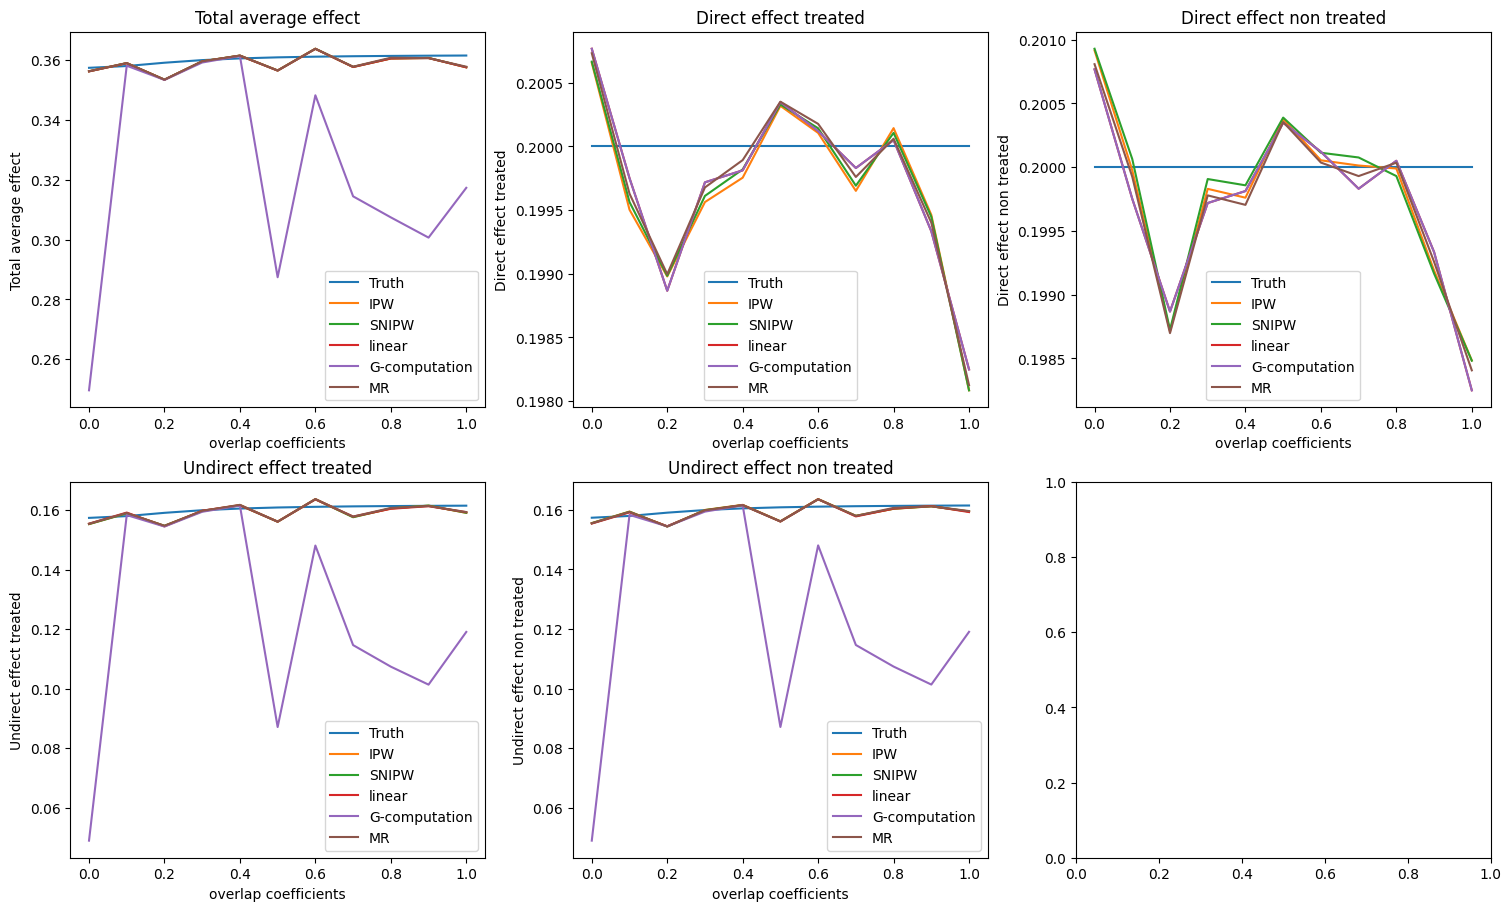

In [314]:
fig, axs = plt.subplots(2, 3, figsize=(15, 9), layout='constrained')


axs[0][0].plot(list_overlap_coefficients, total_effect_df['Truth'], label='Truth')
axs[0][0].plot(list_overlap_coefficients, total_effect_df['IPW'], label='IPW')
axs[0][0].plot(list_overlap_coefficients, total_effect_df['SNIPW'], label='SNIPW')
axs[0][0].plot(list_overlap_coefficients, total_effect_df['linear'], label='linear')
axs[0][0].plot(list_overlap_coefficients, total_effect_df['G-computation'], label='G-computation')
axs[0][0].plot(list_overlap_coefficients, total_effect_df['MR'], label='MR')
axs[0][0].set_xlabel('overlap coefficients')
axs[0][0].set_ylabel('Total average effect')
axs[0][0].legend()
axs[0][0].set_title('Total average effect')

axs[0][1].plot(list_overlap_coefficients, direct_effect_treated_df['Truth'], label='Truth')
axs[0][1].plot(list_overlap_coefficients, direct_effect_treated_df['IPW'], label='IPW')
axs[0][1].plot(list_overlap_coefficients, direct_effect_treated_df['SNIPW'], label='SNIPW')
axs[0][1].plot(list_overlap_coefficients, direct_effect_treated_df['linear'], label='linear')
axs[0][1].plot(list_overlap_coefficients, direct_effect_treated_df['G-computation'], label='G-computation')
axs[0][1].plot(list_overlap_coefficients, direct_effect_treated_df['MR'], label='MR')
axs[0][1].set_xlabel('overlap coefficients')
axs[0][1].set_ylabel('Direct effect treated')
axs[0][1].legend()
axs[0][1].set_title('Direct effect treated')

axs[0][2].plot(list_overlap_coefficients, direct_effect_non_treated_df['Truth'], label='Truth')
axs[0][2].plot(list_overlap_coefficients, direct_effect_non_treated_df['IPW'], label='IPW')
axs[0][2].plot(list_overlap_coefficients, direct_effect_non_treated_df['SNIPW'], label='SNIPW')
axs[0][2].plot(list_overlap_coefficients, direct_effect_non_treated_df['linear'], label='linear')
axs[0][2].plot(list_overlap_coefficients, direct_effect_non_treated_df['G-computation'], label='G-computation')
axs[0][2].plot(list_overlap_coefficients, direct_effect_non_treated_df['MR'], label='MR')
axs[0][2].set_xlabel('overlap coefficients')
axs[0][2].set_ylabel('Direct effect non treated')
axs[0][2].legend()
axs[0][2].set_title('Direct effect non treated')


axs[1][0].plot(list_overlap_coefficients, indirect_effect_treated_df['Truth'], label='Truth')
axs[1][0].plot(list_overlap_coefficients, indirect_effect_treated_df['IPW'], label='IPW')
axs[1][0].plot(list_overlap_coefficients, indirect_effect_treated_df['SNIPW'], label='SNIPW')
axs[1][0].plot(list_overlap_coefficients, indirect_effect_treated_df['linear'], label='linear')
axs[1][0].plot(list_overlap_coefficients, indirect_effect_treated_df['G-computation'], label='G-computation')
axs[1][0].plot(list_overlap_coefficients, indirect_effect_treated_df['MR'], label='MR')
axs[1][0].set_xlabel('overlap coefficients')
axs[1][0].set_ylabel('Undirect effect treated')
axs[1][0].legend()
axs[1][0].set_title('Undirect effect treated')

axs[1][1].plot(list_overlap_coefficients, indirect_effect_non_treated_df['Truth'], label='Truth')
axs[1][1].plot(list_overlap_coefficients, indirect_effect_non_treated_df['IPW'], label='IPW')
axs[1][1].plot(list_overlap_coefficients, indirect_effect_non_treated_df['SNIPW'], label='SNIPW')
axs[1][1].plot(list_overlap_coefficients, indirect_effect_non_treated_df['linear'], label='linear')
axs[1][1].plot(list_overlap_coefficients, indirect_effect_non_treated_df['G-computation'], label='G-computation')
axs[1][1].plot(list_overlap_coefficients, indirect_effect_non_treated_df['MR'], label='MR')
axs[1][1].set_xlabel('overlap coefficients')
axs[1][1].set_ylabel('Undirect effect non treated')
axs[1][1].legend()
axs[1][1].set_title('Undirect effect non treated')

In [265]:
direct_effect_treated_dic ={
    'Truth': [],
    'IPW': [],
    'SNIPW': [],
    'linear': [],
    'G-computation': [],
    'MR': []
}

direct_effect_df = pd.DataFrame(direct_effect_treated_dic)
results_df

,Truth,IPW,SNIPW,linear,G-computation,MR
causal_effects,,,,,,
total effect $\tau$,0.361531,0.351076,0.351072,0.350734,0.300138,0.350750
direct effect treated $\theta(1)$,0.200000,0.196000,0.195905,0.195893,0.195893,0.195904
direct effect non treated $\theta(0)$,0.200000,0.195963,0.195830,0.195893,0.195893,0.195913
indirect effect treated $\delta(1)$,0.161531,0.155113,0.155242,0.154841,0.104246,0.154838
indirect effect untreated $\delta(0)$,0.161531,0.155076,0.155166,0.154841,0.104246,0.154846


In [284]:
results_df.iloc[1].values

array([0.2       , 0.19599953, 0.1959052 , 0.19589261, 0.19589261,
       0.19590424])

In [285]:
direct_effect_df.loc[len(direct_effect_df.index)] = results_df.iloc[1].values

In [286]:
direct_effect_df

,Truth,IPW,SNIPW,linear,G-computation,MR
0,0.2,0.196,0.195905,0.195893,0.195893,0.195904


In [280]:
direct_effect_df.iloc[0] = results_df.iloc[1]

IndexError: iloc cannot enlarge its target object

In [317]:
n_samples = 10000
causal_data, causal_effects = generate_causal_data(dataset_name, n_samples, False)
x, t, m, y = causal_data
classifier_x, classifier_xm = get_classifier(params['regularization'], params['forest'], params['calibration'])
p_x, p_xm = estimate_probabilities(t, m, x, params['crossfit'], classifier_x, classifier_xm)

/Users/hzenati/miniconda3/envs/mind/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hzenati/miniconda3/envs/mind/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [318]:
m

array([[1.2988589 ],
       [1.35519484],
       [0.43082362],
       ...,
       [1.50852977],
       [0.61602638],
       [0.39563278]])

In [319]:
x_clf = LogisticRegressionCV(Cs=cs, cv=CV_FOLDS)
xm_clf = LogisticRegressionCV(Cs=cs, cv=CV_FOLDS)
# x_clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)
# xm_clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)
# calib_method = 'sigmoid'
# x_clf = CalibratedClassifierCV(x_clf, method=calib_method)
# xm_clf = CalibratedClassifierCV(xm_clf, method=calib_method)
        
n = len(t)
train_test_list = [[np.arange(n), np.arange(n)]]

p_x, p_xm = [np.zeros(n) for h in range(2)]
# compute propensity scores
if len(x.shape) == 1:
    x = x.reshape(-1, 1)
if len(m.shape) == 1:
    m = m.reshape(-1, 1)

train_test_list = get_train_test_lists(crossfit, n)

for train_index, test_index in train_test_list:
    x_clf = x_clf.fit(x[train_index, :], t[train_index])
    xm_clf = xm_clf.fit(np.hstack((x, m))[train_index, :], t[train_index])
    p_x[test_index] = x_clf.predict_proba(x[test_index, :])[:, 1]
    p_xm[test_index] = xm_clf.predict_proba(
        np.hstack((x, m))[test_index, :])[:, 1]
    

/Users/hzenati/miniconda3/envs/mind/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hzenati/miniconda3/envs/mind/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [231]:
p_xm

array([0.55134251, 0.54009824, 0.44951737, ..., 0.47679434, 0.54150298,
       0.44453564])

In [232]:
x, m

(array([[-0.14573364,  1.14127987],
        [ 0.1143222 ,  0.41886898],
        [ 0.41700926,  0.1057243 ],
        ...,
        [-0.97086447, -1.2636025 ],
        [-0.1728669 ,  0.58630943],
        [ 0.27764468,  0.1388676 ]]),
 array([[1.29800425],
        [1.2368184 ],
        [0.55538922],
        ...,
        [0.83712826],
        [1.24495826],
        [0.51778423]]))

In [219]:
# effects_SNIPW = SNIPW(y, t, m, x, params['trim'], p_x, p_xm, params['clip'])
# effects_IPW = IPW(y, t, m, x, params['trim'], p_x, p_xm, params['clip'])
# effects_linear = ols_mediation(y, t, m, x)
# data = {'causal_effects': list_causal_effects}
# data['Truth'] = causal_effects
# data['IPW'] = effects_IPW
# data['SNIPW'] = effects_SNIPW
# data['linear'] = effects_linear
# # data['G-computation'] = effects_g_computation
# # data['MR'] = effects_MR
# df = pd.DataFrame(data)
# df = df[:-1]
# df.set_index('causal_effects', inplace=True)
# df

In [220]:
# effects_SNIPW

In [320]:
# p_x = np.ones_like(p_x)*0.5
# p_xm = np.ones_like(p_x)*0.5

t = t.squeeze()
m = m.squeeze()

trim, clip = params['trim'], params['clip']
ind = ((p_xm > trim) & (p_xm < (1 - trim)))
y, t, p_x, p_xm = y[ind], t[ind], p_x[ind], p_xm[ind]

# note on the names, ytmt' = Y(t, M(t')), the treatment needs to be
# binary but not the mediator
# p_x = np.clip(p_x, clip, 1 - clip)
# p_xm = np.clip(p_xm, clip, 1 - clip)

In [321]:
p_xm

array([0.87468474, 0.86611361, 0.10836141, ..., 0.85700136, 0.24415944,
       0.09631354])

In [322]:
t, m

(array([1, 1, 0, ..., 1, 0, 0]),
 array([1.2988589 , 1.35519484, 0.43082362, ..., 1.50852977, 0.61602638,
        0.39563278]))

In [323]:
p_x, p_xm

(array([0.49911269, 0.49910858, 0.49911134, ..., 0.49905853, 0.4991041 ,
        0.49910848]),
 array([0.87468474, 0.86611361, 0.10836141, ..., 0.85700136, 0.24415944,
        0.09631354]))

In [249]:
y1m1, y1m0, y0m0, y0m1

(1.459935393087433,
 1.4510845752122383,
 0.45031871376382127,
 0.4592350721494876)

In [251]:
np.mean(y[t==1]) - np.mean(y[t==0])

1.0096386399749133

In [242]:
y[t == 0], p_xm[t==0], m[t==0]

(array([0.52450131, 0.52802596, 0.42351199, ..., 0.41328875, 0.75890838,
        0.31698331]),
 array([0.44951737, 0.44707598, 0.43042701, ..., 0.44875362, 0.47679434,
        0.44453564]),
 array([[0.55538922],
        [0.50750763],
        [0.36399668],
        ...,
        [0.53309387],
        [0.83712826],
        [0.51778423]]))

In [229]:
p_x, p_xm

(array([0.49992031, 0.49999308, 0.50004991, ..., 0.49993754, 0.49994602,
        0.50002961]),
 array([0.55134251, 0.54009824, 0.44951737, ..., 0.47679434, 0.54150298,
        0.44453564]))

In [324]:
y1m1 = np.sum(y * t / p_x) / np.sum(t / p_x)
y1m0 = np.sum(y * t * (1 - p_xm) / (p_xm * (1 - p_x))) / np.sum(t * (1 - p_xm) / (p_xm * (1 - p_x)))
y0m0 = np.sum(y * (1 - t) / (1 - p_x)) / np.sum((1 - t) / (1 - p_x))
y0m1 = np.sum(y * (1 - t) * p_xm / ((1 - p_xm) * p_x)) / np.sum((1 - t) * p_xm / ((1 - p_xm) * p_x))

In [325]:
total = y1m1 - y0m0
direct1 = y1m1 - y0m1
direct0 = y1m0 - y0m0
indirect1 = y1m1 - y1m0
indirect0 = y0m1 - y0m0

In [326]:
total, direct1, direct0, indirect1, indirect0

(1.0135569515076976,
 0.9705545005708663,
 0.9718376688842252,
 0.041719282623472465,
 0.04300245093683125)

In [327]:
causal_effects

[1.01, 0.2, 0.2, array([0.81]), array([0.81]), 0]

In [328]:
effects_linear = ols_mediation(y, t, m, x)
effects_linear

[1.0137213660591147,
 0.20538623501610792,
 0.20538623501610792,
 0.8083351310430068,
 0.8083351310430068,
 None]

In [213]:
buckets = np.array([0., 0.2, 0.4, 0.6, 0.8, 1, 2])
inds_bucketized = np.digitize(m, buckets)
m_bucketized = buckets[inds_bucketized]

In [31]:
t

array([0, 0, 0, ..., 0, 0, 1])

In [32]:
y1m0, y1m1

(0.7604472500700034, 0.9298412249266818)

In [33]:
y1m1, y0m0

(0.9298412249266818, 0.561811808050858)

In [34]:
y0m1

0.7304799154421578

In [35]:
p_x

array([0.50738952, 0.50589069, 0.5043246 , ..., 0.51055525, 0.5073326 ,
       0.5050081 ])

In [36]:
p_xm

array([0.3441798 , 0.57279379, 0.56999283, ..., 0.34006814, 0.34241638,
       0.33865712])

In [37]:
y

array([-0.01977597,  0.83585177,  1.01397798, ...,  0.05477241,
       -0.0568483 ,  0.21183378])

In [38]:
y[t==1]

array([1.06728555, 0.97410996, 1.02338864, ..., 0.20753601, 1.15600895,
       0.21183378])

In [39]:
t.squeeze()==[1]

array([False, False, False, ..., False, False,  True])

In [40]:
n = y.shape[0]

In [41]:
y[t.squeeze()==[1]].sum()/n

0.4708003280218567

In [42]:
y[t.squeeze()==[0]].sum()/n

0.2774302058941099

In [43]:
p_xm

array([0.3441798 , 0.57279379, 0.56999283, ..., 0.34006814, 0.34241638,
       0.33865712])

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations

import seaborn as sns
# sns.set_context('talk')
# sns.set_style('whitegrid')

In [45]:
p_t = 0.5*np.ones_like(p_x)
th_p_t_mx = 0.5*np.ones_like(p_x)

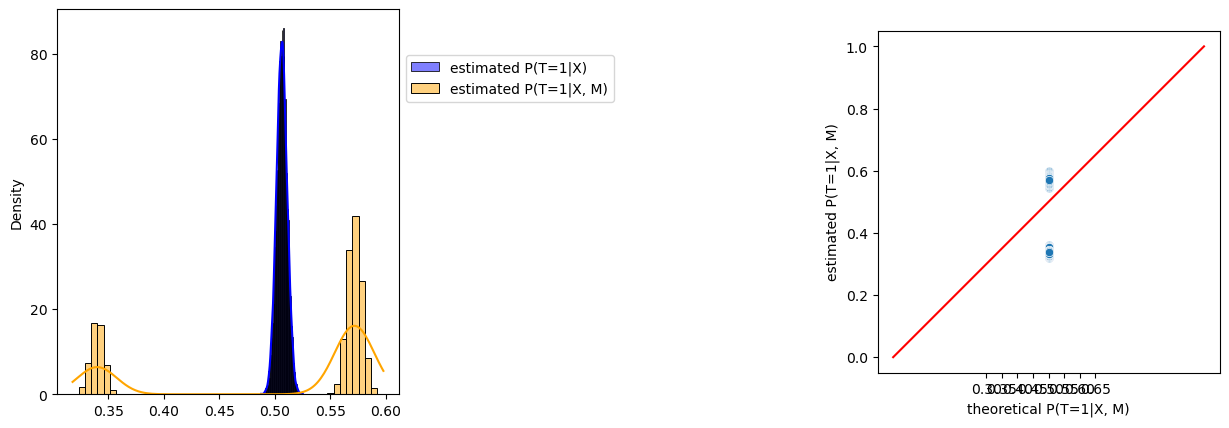

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# sns.kdeplot(p_t, color="blue", ls='--', ax=axes[0], label='theoretical P(T=1|X)')
sns.histplot(p_x, color="blue", kde=True, stat='density', ax=axes[0], label='estimated P(T=1|X)')
# sns.kdeplot(th_p_t_mx, color="orange", ls='--', ax=axes[0], label='theoretical P(T=1|X, M)')
sns.histplot(p_xm, color="orange", kde=True, bins=50, stat='density', ax=axes[0], label='estimated P(T=1|X, M)')

axes[0].legend(bbox_to_anchor=[1, 0.9])

ax = axes[1]
sns.scatterplot(x=th_p_t_mx[ind], y=p_xm, ax=ax)
ax.set_xticks(ax.get_yticks())
ax.set_aspect('equal', adjustable='box')
plt.plot([0, 1], [0, 1], 'red')
plt.ylabel('estimated P(T=1|X, M)')
plt.xlabel('theoretical P(T=1|X, M)')
plt.subplots_adjust(wspace=1.4)

In [22]:
interaction=False
forest=False
crossfit=0
calibration=True
regularization=True
calib_method='sigmoid'

In [23]:
m_bucketized

array([[2. ],
       [0.6],
       [0.8],
       ...,
       [2. ],
       [2. ],
       [0.8]])

In [31]:
if regularization:
    alphas = ALPHAS
    cs = ALPHAS
else:
    alphas = [0.0]
    cs = [np.inf]
m = inds_bucketized
n = len(y)
if len(x.shape) == 1:
    x = x.reshape(-1, 1)
if len(m.shape) == 1:
    mr = m.reshape(-1, 1)
else:
    mr = np.copy(m)
if len(t.shape) == 1:
    t = t.reshape(-1, 1)

t0 = np.zeros((n, 1))
t1 = np.ones((n, 1))
m0 = np.zeros((n, 1))
m1 = np.ones((n, 1))

if crossfit < 2:
    train_test_list = [[np.arange(n), np.arange(n)]]
else:
    kf = KFold(n_splits=crossfit)
    train_test_list = list()
    for train_index, test_index in kf.split(x):
        train_test_list.append([train_index, test_index])
mu_1bx, mu_0bx, f_0bx, f_1bx = \
    [np.zeros(n) for h in range(4)]

for train_index, test_index in train_test_list:
    if not forest:
        y_reg = RidgeCV(alphas=alphas, cv=CV_FOLDS)\
            .fit(get_interactions(interaction, x, t, mr)[train_index, :], y[train_index])
        pre_m_prob = LogisticRegressionCV(Cs=cs, cv=CV_FOLDS)\
            .fit(get_interactions(interaction, t, x)[train_index, :], m.ravel()[train_index])
    else:
        y_reg = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)\
            .fit(get_interactions(interaction, x, t, mr)[train_index, :], y[train_index])
        pre_m_prob = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)\
            .fit(get_interactions(interaction, t, x)[train_index, :], m.ravel()[train_index])
    if calibration:
        m_prob = CalibratedClassifierCV(pre_m_prob, method=calib_method)\
            .fit(get_interactions(
                interaction, t, x)[train_index, :], m.ravel()[train_index])
    else:
        m_prob = pre_m_prob
#     mu_11x[test_index] = y_reg.predict(get_interactions(interaction, x, t1, m1)[test_index, :])
#     mu_10x[test_index] = y_reg.predict(get_interactions(interaction, x, t1, m0)[test_index, :])
#     mu_01x[test_index] = y_reg.predict(get_interactions(interaction, x, t0, m1)[test_index, :])
#     mu_00x[test_index] = y_reg.predict(get_interactions(interaction, x, t0, m0)[test_index, :])
#     f_00x[test_index] = m_prob.predict_proba(get_interactions(interaction, t0, x)[test_index, :])[:, 0]
#     f_01x[test_index] = m_prob.predict_proba(get_interactions(interaction, t0, x)[test_index, :])[:, 1]
#     f_10x[test_index] = m_prob.predict_proba(get_interactions(interaction, t1, x)[test_index, :])[:, 0]
#     f_11x[test_index] = m_prob.predict_proba(get_interactions(interaction, t1, x)[test_index, :])[:, 1]

    buckets = [0., 0.2, 0.4, 0.6, 0.8, 1]

    direct_effect_treated = 0
    direct_effect_control = 0
    indirect_effect_treated = 0
    indirect_effect_control = 0

    for i, b in enumerate(buckets):

        mb = m1 * b
        mu_1bx = y_reg.predict(get_interactions(interaction, x, t1, mb)[test_index, :])
        mu_0bx = y_reg.predict(get_interactions(interaction, x, t0, mb)[test_index, :])
        f_1bx[test_index] = m_prob.predict_proba(get_interactions(interaction, t1, x)[test_index, :])[:, i]
        f_0bx[test_index] = m_prob.predict_proba(get_interactions(interaction, t0, x)[test_index, :])[:, i]
        direct_effect_ib = mu_1bx - mu_0bx
        direct_effect_treated += direct_effect_ib * f_1bx
        direct_effect_control += direct_effect_ib * f_0bx
        indirect_effect_ib = f_1bx - f_0bx
        indirect_effect_treated += indirect_effect_ib * mu_1bx
        indirect_effect_control += indirect_effect_ib * mu_0bx

    direct_effect_treated = direct_effect_treated.sum() / n
    direct_effect_control = direct_effect_control.sum() / n
    indirect_effect_treated = indirect_effect_treated.sum() / n
    indirect_effect_control = indirect_effect_control.sum() / n


/Users/hzenati/miniconda3/envs/mind/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hzenati/miniconda3/envs/mind/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

In [32]:
causal_effects

[1.01, 0.2, 0.2, array([0.81]), array([0.81]), 0]

In [33]:
direct_effect_treated, direct_effect_control, indirect_effect_treated, indirect_effect_control

(0.06149657232696939,
 0.734283505124638,
 -0.8715992158774716,
 -0.19881228307980306)

In [20]:
buckets = [0., 0.2, 0.4, 0.6, 0.8, 1]

direct effect_treated = 0
direct_effect_control = 0
indirect_effect_treated = 0
indirect_effect_control = 0

for i, b in enumerate(buckets):
    
    mb = m1 * b
    mu_1bx = y_reg.predict(get_interactions(interaction, x, t1, mb)[test_index, :])
    mu_0bx = y_reg.predict(get_interactions(interaction, x, t0, mb)[test_index, :])
    f_1bx[test_index] = m_prob.predict_proba(get_interactions(interaction, t1, x)[test_index, :])[:, i]
    f_0bx[test_index] = m_prob.predict_proba(get_interactions(interaction, t0, x)[test_index, :])[:, i]
    direct_effect_ib = mu_1bx - mu_0bx
    direct_effect_treated += direct_effect_ib * f_1bx
    direct_effect_control += direct_effect_ib * f_0bx
    indirect_effect_ib = f_1bx - f_0bx
    indirect_effect_treated += indirect_effect_ib * mu_1bx
    indirect_effect_control += indirect_effect_ib * mu_0bx
    
direct_effect_treated = direct_effect_treated.sum() / n
direct_effect_control = direct_effect_control.sum() / n
indirect_effect_treated = indirect_effect_treated.sum() / n
indirect_effect_control = indirect_effect_control.sum() / n

SyntaxError: invalid syntax (619621430.py, line 3)

In [62]:
test_index

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [ ]:
direct_effect_i1 = mu_11x - mu_01x
direct_effect_i0 = mu_10x - mu_00x
direct_effect_treated = (direct_effect_i1 * f_11x + direct_effect_i0 * f_10x).sum() / n
direct_effect_control = (direct_effect_i1 * f_01x + direct_effect_i0 * f_00x).sum() / n
indirect_effect_i1 = f_11x - f_01x
indirect_effect_i0 = f_10x - f_00x
indirect_effect_treated = (indirect_effect_i1 * mu_11x + indirect_effect_i0 * mu_10x).sum() / n
indirect_effect_control = (indirect_effect_i1 * mu_01x + indirect_effect_i0 * mu_00x).sum() / n
total_effect = direct_effect_control + indirect_effect_treated

In [63]:
m

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [25]:
zmar = np.array([0.2, 6.4, 3.0, 1.6])
bins = np.array([-np.inf, 0.0, 1.0, 2.5, 4.0, 10.0])
inds = np.digitize(zmar, bins)

In [26]:
inds

array([2, 5, 4, 3])

In [27]:
bins[inds]

array([ 1. , 10. ,  4. ,  2.5])

In [28]:
inds

array([2, 5, 4, 3])

In [92]:
m_classes = np.arange(buckets.shape[0])

In [29]:
bins[inds]

array([ 1. , 10. ,  4. ,  2.5])